# Derived from Geron 11_deep_learning.ipynb

We will provide a quick introduction into programming with TensorFlow.

We revist our old friend, MNIST digit classification and provide two solutions
- the first using "raw", low-level TensorFlow
- the second using the high-level Keras API

In [0]:
import tensorflow as tf

import numpy as np
import os

import pdb

# Raw TensorFlow

# TensorFlow.layers

We will build an MNIST classifier using TensorFlow.layers

## Get the MNIST dataset
- data pre-split into training and test sets
  - flatten the images from 2 dimensional to 1 dimensional (makes it easier to feed into first layer)
  - create validation set from part of training
- "normalize" the inputs: change pixel range from [0,255] to [0,1]

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Determine 
# - the dimensions of the input by examining the first training example
# - the dimensions of the output (number of classes) by examinimg the targets
input_size = np.prod(X_train[0].shape)
output_size = np.unique(y_train).shape[0]

# input image dimensions
img_rows, img_cols = X_train[0].shape[0:2]

valid_size = X_train.shape[0] // 10

# Flatten the data to one dimension and normalize to range [0,1]
X_train = X_train.astype(np.float32).reshape(-1, input_size) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, input_size) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:valid_size], X_train[valid_size:]
y_valid, y_train = y_train[:valid_size], y_train[valid_size:]

In [40]:
X_train.shape

(54000, 784)

In [0]:
# Placeholders for input X, target y
#  The first dimension (None) is for the batch size

X = tf.placeholder(tf.float32, shape=(None, input_size), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

## Create function to return mini-batches

In [0]:
def next_batch(X, y, batch_size, shuffle=True):
  """
  Generator to return batches from X and y
  
  Parameters
  ----------
  X: ndarray
  y: ndarray.  The first dimension of X and y must be the same
  batch_size: Int.  The size of the slice (of X and y) to return in each batch
  shutffle: Boolean.  Sample X, y in random order if True
  
  Yields
  ------
  X_batch, y_batch: a 2-tuple of ndarrays, 
  - where X_batch is a slice (of size at most batch_size) of X
  - where y_batch is a slice of y (same first dimension as X_batch)
  
  If first dimension of X is not evenly divisible by batch size, the final batch will 
  be of size smaller than batch_size
  """
  
  # Randomize the indices
  if shuffle:
    idx = np.random.permutation(len(X))
  else:
    idx = np.arange( len(X) )

  # Return a batch of size (at most) batch_size, 
  # starting at idx[next_start] 
  next_start = 0

  n_batches = len(X) // batch_size
  
  while next_start < len(X):
    # Get a batch of indices from idx, starting a idx[next_start] and ending at idx[next_end]
    next_end   = min(next_start + batch_size, len(X))
    X_batch, y_batch = X[ idx[next_start:next_end] ], y[ idx[next_start:next_end] ]

    # Advance next_start to start of next batch
    next_start = next_start + batch_size

    # Return a batch
    yield X_batch, y_batch


## Build the computation graph

In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [0]:
reset_graph()

(n_hidden_1, n_hidden_2) = (100, 30)

# Placeholders for input X, target y
#  The first dimension (None) is for the batch size
X = tf.placeholder(tf.float32, shape=(None, input_size), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden_1, activation="relu", name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden_2, activation="relu", name="hidden2")
    logits = tf.layers.dense(hidden2, output_size, name="outputs_")

## Create a loss node
- Use cross entropy as loss 
  - we are comparing the probability vector computed by the graph (logits) with the target probability vector (y)
  
Ordinarily we would need to
- convert the scores (logits) vector to a probability vector  by a *softmax* activation on the "outputs" layer
- convert the target to a one-hot vector (length equal to number of target classes, which is also length of probability vector)
- compare the two vectors with cross_entropy

TensorFlow provides a very convenient method `sparse_softmax_cross_entropy_with_logits` that does all the work for us !
- applies `softmax` to the scores (logits)
- converts integer targets (in range [0, number of classes]) into one-hot vectors (with length equal to number of classes)
- does the cross entropy calculation

In [0]:
with tf.name_scope("loss"):
  # xentropy is a tensor whose first dimension is the batch size
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  
  # Find the loss across the examples in the batch by summing individual example losses
  loss = tf.reduce_mean(xentropy, name="loss")
  


## Create a node to compute accuracy 
-  for each example, compares the element in the logit vector with the highest score (i.e., index of our prediction) to the target
- sums up the number of examples with matching max logit and target

In [0]:
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Create the training operations
- Training operation is an optimizer step that minimizes the loss

In [0]:
learning_rate = 0.01

with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

## Create an initialization node to initialize global variables (i.e., the weights that the optimizer will solve for)


In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Run  the training loop
- Run for multiple "epochs"; an epoch is an entire pass through the training data set
- For each epoch, divide the training set into mini-batches
  - For each mini-batch
    - run the "training operation" (i.e, the optimizer)
    - every few epochs
      - compute the accuracy (by evaluating the graph node that computes accuracy) on the training and validation set
      
In general, we usually continue training
- as long as the validation loss continues to decrease across epochs
- as long as the validation loss is greater than the training loss
  - if the training loss is much lower than the validation (out of sample) loss, we may be overfitting to the training data
  - **Note** that we have stated these conditions in terms of decreasing validation loss, rather than increasing validation accuracy
    - **Question**: *Why should we prefer "loss" to "accuracy" ?*
 

In [0]:
n_epochs = 20
batch_size = 50

modelName = "mnist_first"

save_path = os.path.join(".", modelName + ".ckpt") 

In [50]:
print("Training for {e:d} epochs".format(e=n_epochs))

# Create a session and evaluate the nodes within it
with tf.Session() as sess:
  # Run the initialization step
  init.run()
  
  # This is our main training loop
  # - run for multiple epochs
  # - in each epoch, process the entire training data in mini-batches
  for epoch in range(n_epochs):
    # Process each of the mini-batches, evaluating the training operation on each
    for X_batch, y_batch in next_batch(X_train, y_train, batch_size, shuffle=True):
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
    # Measure the training and validation accuracy every few epochs 
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch {e:d} training batch accuracy {ta:3.2f}%, validation set accuracy {va:3.2f}%:".format(e=epoch, ta=100*acc_batch, va=100*acc_valid) )

  # Save the session so we can pick up again      
  save_path = saver.save(sess, save_path)
  
  print("Trained")

Training for 20 epochs
Epoch 0 training batch accuracy 92.00%, validation set accuracy 88.78%:
Epoch 5 training batch accuracy 86.00%, validation set accuracy 94.50%:
Epoch 10 training batch accuracy 96.00%, validation set accuracy 96.02%:
Epoch 15 training batch accuracy 96.00%, validation set accuracy 96.48%:
Trained


Now that the model is trained (and saved) we can feed in test data in order to perform predictions

Note that:
- The graph must always be evaluated in a session
- A new session is completely uninitialized
  - the trained weights are *not* available
- We can restore the state of a previous session, in order to obtain access to the trained model

In [51]:
with tf.Session() as sess:
  # Restore the model, do NOT re-initialize the variables with the "init" node
  saver.restore(sess, save_path)
  
  # We can now evaluate any of the model's nodes, using the trained weights
  # Perform prediction using the test set
  # Recall: the logits for each example is a vector of length, number of classes
  # To convert one vector to a prediction: find the index of the largest logit
  logits_test = logits.eval(feed_dict={X: X_test})
  print("Test logits shape: ", logits_test.shape)
  predictions_test = np.argmax(logits_test, axis=1)
  
  # Show some of the predictins
  num_to_show = 10
  print("Test predictions: \t",  predictions_test[:num_to_show])
  
  print("Test correct ?:\t ",    (predictions_test == y_test)[:num_to_show])
  
  # What is the overall accuracy ?
  acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
  print("Test accuracy {a:3.2f}".format(a=100*acc_test))
  
  

  

INFO:tensorflow:Restoring parameters from ./mnist_first.ckpt
Test logits shape:  (10000, 10)
Test predictions: 	 [7 2 1 0 4 1 4 9 6 9]
Test correct ?:	  [ True  True  True  True  True  True  True  True False  True]
Test accuracy 96.56


# Keras version

That was very instructive (hopefully) but also a lot of detailed work.

It's worthwhile studying the TensorFlow.layers to get a deeper understanding of 
- computation graph
  -definition
  - initialization
  - evaluation
- loss functions:
  - computed per example and summed
- the training loop

Over the years, many people have created higher level abstractions (e.g., `tf.layers.dense` is an abstraction that saves you the trouble of multiplying inputs by weights, adding a bias, and applying an activation) to both simplify and reduce repeated code patterns.

The Keras API is a very high level abstraction (that looks similar to `sklearn` in some regards) that simplifies things a great deal, and will be tightly integrated into TensorFlow 2.0

Let's re-implement this classification problem in Keras

## Boiler plate

Here are some of our standard imports.

Note that - `keras` and - `tensorflow.keras` are two very similar but **distinct** modules !  
- `keras` is a  [project](https://keras.io/) that is separate and distinct from TensorFlow
  - It is an API for Neural Network programming, not a library
  - The API can be implemented for many different compute engines.  TensorFlow is just one engine
  - The Keras project supplies a TensorFlow engine which is **not identical** to Google's tTensorFlow implementation
  
- `tensorflow.keras` is Google's implementation (and extension) of the Keras API

For the most part they are similar, but you can create difficulty if you mix and match.
We will deal exclusively with `tensorflow.keras`, as will be reflected in our import statements.


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model
import IPython


## Build the compuation graph in Keras

In [0]:
mnist_model = Sequential([ layers.Dense(n_hidden_1, activation=tf.nn.relu,    name="hidden1", input_shape=(input_size,)),
                           layers.Dense(n_hidden_2, activation=tf.nn.relu,    name="hidden2"),
                           layers.Dense(output_size,activation=tf.nn.softmax, name="outputs")
                         ]
                        )
    


That was easy !

We used the same conceptual layers as in the TensorFlow.layers implementation and passed them as a list to the `Sequential` model.
Note, however, that the "layers" now come from tf.keras rather than TensorFlow tf.

The `Sequential` model will take the input, feed it to the first layer, and pass the output of layer $i$ to the input of layer $i+1$.

Some things to point out
- when you use the `Sequential` model, you don't supply an explicit `Input` layer (placeholders in TensorFlow.layers)
  - instead: the first (and only the first) layer requires the `input_shape` argument to describe the shape of the input
- Unlike in the TensorFlow.layers code, the  final layer (`outputs`) has an `softmax` activation
  - In TensorFlow.layers, the loss function (`sparse_softmax_cross_entropy_with_logits`) performs its own `softmax`
    - we couldn't find a similar loss function in Keras, so we perform the `softmax` ourself.

### Creating a loss node  and traiining operation in Keras 

The `mnist_model` specifies the layers of the model, but doesn't actually build the computation graphs.
For that, we need to "compile" the model.

The compile step is also where we specify 
- the loss function
- the optimizer step
- other "metrics" (values to measure) to compute in the training loop

Below 
- we will use `sparse_categorical_crossentropy` as the loss (`sparse` because our labels are not one-hot encoded).
- `adam` as our optimizer (could have easily chosen `sgd`in order to be more similar to the TensorFlow.layers code)
- measure training accuracy (`acc`) 

In [0]:
metrics = [ "acc" ]
mnist_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=metrics)


## History and callbacks

Strictly speaking, the next few cells are not absolutely necessary: they go far beyond what our TensorFlow.layers program accomplishes
- call backs
  - these are functions that are called automatically in the training loop
    - `EarlyStopping`is a call back that will terminate the training loop when it is no longer productive to continue (e.g., when validation loss levels off)
    - `ModelCheckpoint` is a call back that will create intermediate snapshots of our model (including the parameters/weights it has learned)
      - We will create a checkpoint whenever accuracy improves.  So if further training reduces accuracy, we can restore back to the "best" parameter values.
      - This means we can re-start the model and continue to train without losing the "best" values.
      - In the TensorFlow.layers code, we only created a single checkpoint at the end of training
  

In [0]:
import matplotlib.pyplot as plt

def plot_training(history, metrics=[]):
    """
    Plot training and validation statistics
    - accuracy vs epoch number
    - loss     vs epoch number

    From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
    """  

    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.figure()

    for metric in metrics:
      metric_value = history.history[metric]
      plt.plot(epochs, metric_value, 'b', label="Training " + metric)
      plt.title('Training  accuracy')
      plt.legend()

    plt.show()

In [56]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

import os

logs_dir="logs/fit/"
os.makedirs( ".", exist_ok=True)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
log_dir= os.path.join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Create call backs
- Early Stopping
- Model Checkpoint

In [0]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

callbacks = [ es_callback,
              ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
          ]


## Run the training loop in Keras

Now that the model is compiled, we can run `fit` on our training (and validation) data sets/

This is very much  like `sklearn`.

Note
- We don't have to construct our own training loop
- We don't have to create code to deliver mini-batches
- We don't have to insert code to display metrics (like accuracy)
- We don't have to run for the full set of epochs, because of Early Stopping

See how much simpler this step is compared to TensorFlow.layers.

In [58]:
history = mnist_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), shuffle=True, callbacks=callbacks)




Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 3s 55us/sample - loss: 0.3126 - acc: 0.9100 - val_loss: 0.1654 - val_acc: 0.9522
Epoch 2/20
54000/54000 [==============================] - 3s 52us/sample - loss: 0.1376 - acc: 0.9596 - val_loss: 0.1087 - val_acc: 0.9675
Epoch 3/20
54000/54000 [==============================] - 3s 50us/sample - loss: 0.0967 - acc: 0.9710 - val_loss: 0.1040 - val_acc: 0.9678
Epoch 4/20
54000/54000 [==============================] - 3s 50us/sample - loss: 0.0738 - acc: 0.9770 - val_loss: 0.0937 - val_acc: 0.9712
Epoch 5/20
54000/54000 [==============================] - 3s 54us/sample - loss: 0.0584 - acc: 0.9817 - val_loss: 0.0984 - val_acc: 0.9698
Epoch 6/20
54000/54000 [==============================] - 3s 60us/sample - loss: 0.0484 - acc: 0.9848 - val_loss: 0.0953 - val_acc: 0.9742


### Compute the accuracy on the test set

In [59]:
test_loss, test_accuracy = mnist_model.evaluate(X_test, y_test)
print("Test dataset: loss={tl:5.4f}, accuracy={ta:5.4f}".format(tl=test_loss, ta=test_accuracy))

10000/10000 [==============================] - 0s 34us/sample - loss: 0.0930 - acc: 0.9719
Test dataset: loss=0.0930, accuracy=0.9719


## See the training history

The `fit` method returns a `history` object, which contains a time-series (across the epochs) of each metric.

You automatically get a `loss` metric so you can see how quickly your training loss decreases.

In the compile step, you can add other metric (like accuracy, both for training and validation).

Because these metrics are time series, we can visualize them.

In [60]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

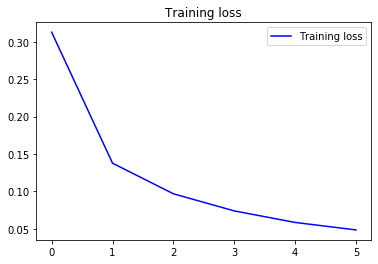

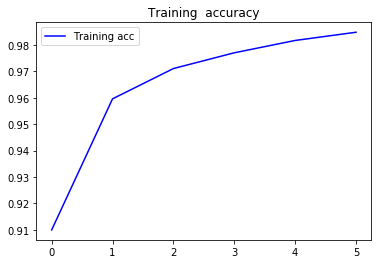

In [61]:
plot_training(history, metrics)

## Use the model for prediction

Just as with `sklearn`, once we have fit the model, we can use the `predict` method to map inputs to predictions.
- Remember: the `outputs` layer has 10 elements, one per output class (so it is one-hot encoded)

In [62]:
predictions = mnist_model.predict(X_test)
predictions.shape

(10000, 10)

## Examine the model

Observe the number of parameters (weights) that the model requires.  Is it larger than you thought ?

In [63]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 30)                3030      
_________________________________________________________________
outputs (Dense)              (None, 10)                310       
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


## Bonus: Visualize the model's layers !


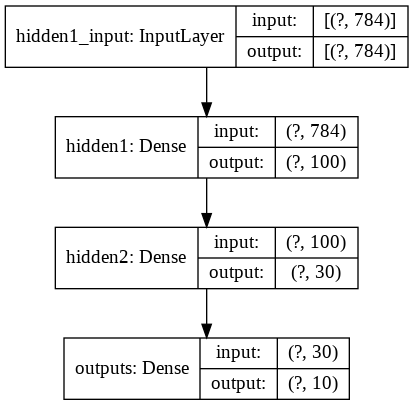

In [64]:
plot_model(mnist_model, "mnist_model.png", show_shapes=True)
IPython.display.Image(  "mnist_model.png")

## Save the model (architecture + weights + optimizer state))

In [0]:
from tensorflow.keras.models import load_model

modelName = "mnist_first"

model_path = os.path.join(".", modelName + ".h5") 
mnist_model.save(model_path)  # creates a HDF5 file model_path


## Load a saved model

In [0]:
# returns a compiled model
# identical to the previous one
mnist_model_1 = load_model(model_path)

### Show that the restored model works

In [67]:
mnist_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 30)                3030      
_________________________________________________________________
outputs (Dense)              (None, 10)                310       
Total params: 81,840
Trainable params: 81,840
Non-trainable params: 0
_________________________________________________________________


In [68]:
predictions_1 = mnist_model_1.predict(X_test)
predictions_1.shape

all_match = np.all(predictions == predictions_1)
if all_match:
  answer = "YES"
else:
  answer = "NO"

print("Live model and restore model results match ?", answer)

Live model and restore model results match ? YES
